**Meta Learning:** 

This is a key point of using ML-based models for forecasting: more often than not, ML models (especially deep learning models)  
need to be trained on large amounts of data, which often means a large amount of separate yet related time series.

We could think about getting more data by not combining the two series but instead use all the available series separately for training.  
Also we could think of augmenting the time series by reversing it but i guess this is a bit of a stupid idea.

**Backtesting:**  
I should backtest the model to see how much overfitting is involved. This will really put the hyperparams to the test but requires retraining the model for each backtest.


**Ensembling:**  
If we have 3 good models, let's say prophet, linear regression and a ml base algo like randomforest, we could test if we gain something from ensembling them.

In [22]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from darts                              import TimeSeries
from darts.models                       import DLinearModel
from darts.dataprocessing.transformers  import Scaler
from darts.utils.timeseries_generation  import datetime_attribute_timeseries
from darts.utils.likelihood_models      import QuantileRegression

from pytorch_lightning.callbacks   import EarlyStopping
from torch.optim.lr_scheduler      import ReduceLROnPlateau
from torch.optim                   import Adam

from sklearn.metrics import mean_squared_error

In [26]:
pdf = pd.read_csv("../../data/daily/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["y"] = (pdf["NE5_GWh"].values + pdf["NE7_GWh"].values)
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

#split data in train val and test
#2657/365/225 days in ratio 
split = len(pdf)-365-200
pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+365], pdf.iloc[split+365:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_14504\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,y
Timestamp,
2015-01-01,6.709087
2015-01-02,7.073348
2015-01-03,7.149544
2015-01-04,6.724467
2015-01-05,8.585045
...,...
2023-06-30,7.247760
2023-07-01,6.168368
2023-07-02,5.750607


In [27]:
ytrain = TimeSeries.from_dataframe(pdf_train)
yval   = TimeSeries.from_dataframe(pdf_val)
ytest  = TimeSeries.from_dataframe(pdf_test)
ytotal = TimeSeries.from_dataframe(pdf)


In [28]:
encoders = {"datetime_attribute": {"future": ["dayofweek","month", "year"]},"transformer": Scaler()}
#the transformer in the dict above is for the encoder and not for the data. 

In [29]:
model = DLinearModel(
                    input_chunk_length = 100,
                    output_chunk_length = 100,
                    add_encoders = encoders,
                    random_state=16
                    )

model.fit(series=ytrain,val_series=yval,epochs=50,verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.


DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=100, output_chunk_length=100, add_encoders={'datetime_attribute': {'future': ['dayofweek', 'month', 'year']}, 'transformer': Scaler}, random_state=16)

In [30]:
(past_covariates, future_covariates) = model.generate_fit_encodings(ytrain)
past_covariates

(16436.0, 16524.0)

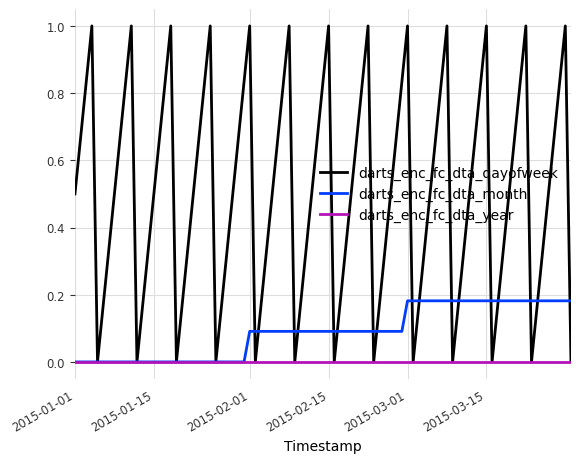

In [31]:
future_covariates.plot()
plt.xlim(pd.Timestamp("2015-01-01"), pd.Timestamp("2015-03-30"))

In [32]:
pred_test = model.predict(n=len(ytest), series=ytrain.append(yval)).pd_series()
pred_val  = model.predict(n=len(yval), series=ytrain).pd_series()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

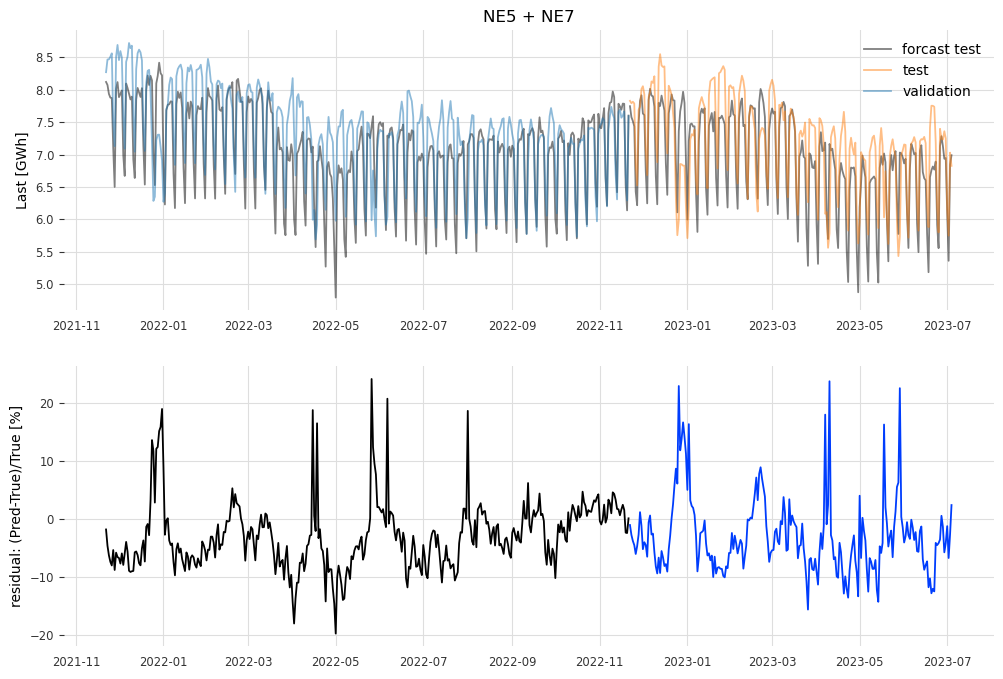

In [33]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(pred_test, color="black", label="forcast test", alpha=0.5)
axes[0].plot(pred_val, color="black", alpha=0.5)

# axes[0].plot(pdf_train[-2*365:], color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="test", alpha=0.5)
axes[0].plot(pdf_val, color="tab:blue", label="validation", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_val.index,  (pred_val.values  - pdf_val.y.values) /  (pdf_val.y.values)*100)
axes[1].plot(pdf_test.index, (pred_test.values - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

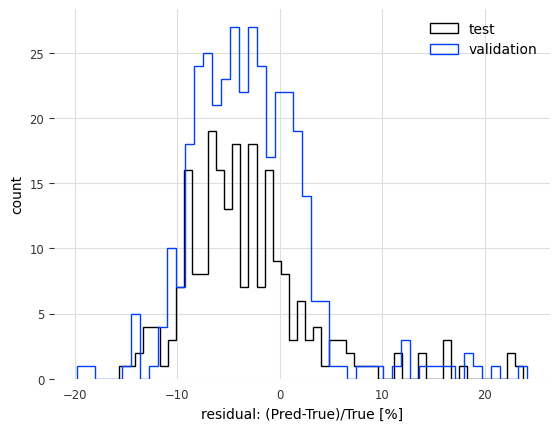

In [34]:
#histogramm of the residuals
plt.hist((pred_test.values - pdf_test.y.values) / (pdf_test.y.values)*100, bins=50, histtype='step', label="test")
plt.hist((pred_val.values -  pdf_val.y.values) /   (pdf_val.y.values)*100, bins=50, histtype='step', label="validation")
plt.legend()
plt.xlabel("residual: (Pred-True)/True [%]")
plt.ylabel("count")
plt.show()

In [35]:
rmse = mean_squared_error(pdf_val.y.values, pred_val.values, squared=False)
print(f"RMSE on validation set: {rmse:.3f}")

rmse = mean_squared_error(pdf_test.y.values,pred_test.values, squared=False)
print(f"RMSE on test set: {rmse:.3f}")

RMSE on validation set: 0.465
RMSE on test set: 0.495


#### Backtesting the model structure, requires the model parameters to be retrained